In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import pyreadstat
from sklearn.decomposition import PCA
import statsmodels.api as sm
import pickle
import DCM

In [2]:
# Clean the risky choice data

df_raw,raw_attr = pyreadstat.read_dta('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing lottery (A) -> higher sure payoff
# 0 - choosing sure payoff (B) -> lower sure payoff
# j: layer / order of choice question
# i: node in the current layer

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_raw['v_110'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_raw['v_110'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_raw = pd.concat([df_raw, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_raw = df_raw.reset_index(names='pid')

q_columns = [col for col in df_raw.columns if 'layer_' in col]

df_melted = df_raw.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_risk', value_name='choice').dropna()

# Calculate the sure payoff for each question
def sure_pay(s):
    parts = s.strip().split('_')

    layer_number = j_max - int(parts[1]) + 1 
    q_number = int(parts[2][1:])

    return 2**(layer_number) + (q_number - 1)*2**(layer_number+1)


df_melted['x'] = df_melted['q_risk'].apply(sure_pay)*10
df_melted['layer'] = df_melted['q_risk'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_risk = pd.merge(right=df_raw[['pid','v_110']].dropna(),left=df_wide,on='pid')
print('Number of people in df_risk:',len(df_risk))

# Predict choices by the majority in each question
count_each_question = df_melted.groupby(['q_risk','x'])['choice'].count()
mean_choice = df_melted.groupby('q_risk')['choice'].mean()
accuracy_per_question = mean_choice * (mean_choice > 0.5) + (1 - mean_choice) * (mean_choice <= 0.5)
accuracy = (accuracy_per_question * count_each_question / count_each_question.sum()).sum()
print('Accuracy (majority of choices):', accuracy)

# This function generate model implied distribution for choice paths
def get_model_implied_dist(model,data,all_args):
    layer_like_list = [f'layer_like_{i}' for i in range(1,6)]
    layer_list = [f'layer_x_{i}' for i in range(1,6)] + layer_like_list

    data[layer_like_list] = model.choiceProb(all_args)

    df_const_like = data.groupby(layer_list).mean().reset_index()[layer_list]
    df_const_like['branch_0'] = 1

    for i in range(1,5):
        choice_option_one =(df_const_like[f'layer_x_{i+1}'] > df_const_like[f'layer_x_{i}'])
        cond_choice_prob = choice_option_one * df_const_like[f'layer_like_{i}'] + \
            (1-choice_option_one) * (1 - df_const_like[f'layer_like_{i}'])
        df_const_like[f'branch_{i}'] = df_const_like[f'branch_{i-1}'] * cond_choice_prob

    _encode = df_const_like.apply(lambda row: np.array([row['branch_4']* (1 - row['layer_like_5']), 
                                            row['branch_4'] * row['layer_like_5']]),axis=1).explode()
    _encode.index = np.arange(1,33)

    return _encode

Number of people in df_risk: 394
Accuracy (majority of choices): 0.6365482233502539


In [3]:
# Clean the intertemporal choice data

df_psm = pd.read_stata('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing SS (A) -> higher LL
# 0 - choosing LL (B) -> lower LL

df_psm['v_195'] = 32 - df_psm['v_195']

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_psm['v_195'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_psm['v_195'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_psm = pd.concat([df_psm, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_psm = df_psm.reset_index(names='pid')

q_columns = [col for col in df_psm.columns if 'layer_' in col]

df_melted = df_psm.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_time', value_name='choice').dropna()

# Encode the LL payoff for each question
node_encoding_reverse = {
    (1, 1): 154,  # Layer 1 (Root), Node 1
    (2, 1): 125,  # Layer 2, Node 1 (Reversed)
    (2, 2): 185,  # Layer 2, Node 2 (Reversed)
    (3, 1): 112,  # Layer 3, Node 1 (Reversed)
    (3, 2): 139,  # Layer 3, Node 2 (Reversed)
    (3, 3): 169,  # Layer 3, Node 3 (Reversed)
    (3, 4): 202,  # Layer 3, Node 4 (Reversed)
    (4, 1): 106,  # Layer 4, Node 1 (Reversed)
    (4, 2): 119,  # Layer 4, Node 2 (Reversed)
    (4, 3): 132,  # Layer 4, Node 3 (Reversed)
    (4, 4): 146,  # Layer 4, Node 4 (Reversed)
    (4, 5): 161,  # Layer 4, Node 5 (Reversed)
    (4, 6): 177,  # Layer 4, Node 6 (Reversed)
    (4, 7): 193,  # Layer 4, Node 7 (Reversed)
    (4, 8): 210,  # Layer 4, Node 8 (Reversed)
    (5, 1): 103,  # Layer 5, Node 1 (Reversed)
    (5, 2): 109,  # Layer 5, Node 2 (Reversed)
    (5, 3): 116,  # Layer 5, Node 3 (Reversed)
    (5, 4): 129,  # Layer 5, Node 4 (Reversed)
    (5, 5): 122,  # Layer 5, Node 5 (Reversed)
    (5, 6): 136,  # Layer 5, Node 6 (Reversed)
    (5, 7): 143,  # Layer 5, Node 7 (Reversed)
    (5, 8): 150,  # Layer 5, Node 8 (Reversed)
    (5, 9): 158,  # Layer 5, Node 9 (Reversed)
    (5, 10): 165, # Layer 5, Node 10 (Reversed)
    (5, 11): 173, # Layer 5, Node 11 (Reversed)
    (5, 12): 181, # Layer 5, Node 12 (Reversed)
    (5, 13): 189, # Layer 5, Node 13 (Reversed)
    (5, 14): 197, # Layer 5, Node 14 (Reversed)
    (5, 15): 206, # Layer 5, Node 15 (Reversed)
    (5, 16): 215  # Layer 5, Node 16 (Reversed)
}

def LL_pay(s):
    parts = s.strip().split('_')

    layer_number = int(parts[1])
    q_number = int(parts[2][1:])

    return node_encoding_reverse.get((layer_number, q_number), "Node not found")


df_melted['x'] = df_melted['q_time'].apply(LL_pay)
df_melted['layer'] = df_melted['q_time'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_time = pd.merge(right=df_psm[['pid','v_195']].dropna(),left=df_wide,on='pid')
print('Number of people in df_time:', len(df_time))

# Predict choices by the majority in each question
count_each_question = df_melted.groupby('q_time')['choice'].count()
mean_choice = df_melted.groupby('q_time')['choice'].mean()
accuracy_per_question = mean_choice * (mean_choice > 0.5) + (1 - mean_choice) * (mean_choice <= 0.5)
accuracy = (accuracy_per_question * count_each_question / count_each_question.sum()).sum()
print('Accuracy (majority of choices):', accuracy)

Number of people in df_time: 353
Accuracy (majority of choices): 0.6113314447592069


In [4]:
# Test preference heterogeneity for risky choices
tab_count = df_raw['v_110'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

prop_test = DCM.proportionTest(tab_count)
prop_test.run(hide=True)
prop_test.get_power(method='fisher')
prop_test.get_power(method='barnard')
prop_test.result.to_csv('prop_result_risk.csv')

print('Fisher p-value:',prop_test.get_overall_pvalue(method='fisher')) 
print('Barnard p-value:',prop_test.get_overall_pvalue(method='barnard')) 
print(prop_test.result[['layer','group','prop_lo','prop_0','prop_hi','p_fisher','p_barnard','power_fisher','power_barnard']])

Fisher p-value: 0.12319997434985816
Barnard p-value: 0.08515129834010468
    layer  group   prop_lo    prop_0   prop_hi  p_fisher  p_barnard  \
5       3      6  1.000000  0.888889  0.375000  1.000000   1.000000   
6       3      7  0.333333  0.538462  0.000000  1.000000   1.000000   
12      0      1  0.492013  0.205584  0.246914  0.999986   1.000000   
3       3      4  0.480000  0.637681  0.181818  0.997971   1.000000   
10      1      1  0.547170  0.492013  0.448052  0.969095   1.000000   
2       3      3  0.770833  0.435294  0.621622  0.958586   1.000000   
7       2      1  0.583333  0.547170  0.505747  0.872307   1.000000   
1       3      2  0.465116  0.505747  0.454545  0.623165   1.000000   
0       3      1  0.566667  0.583333  0.595238  0.499084   0.450650   
4       3      5  0.227273  0.576923  0.400000  0.155697   0.222948   
11      1      2  0.147541  0.246914  0.350000  0.053578   0.211629   
9       2      3  0.576923  0.147541  0.888889  0.074260   0.040291   
8   

In [68]:
# Test preference heterogeneity for intertemporal choices
tab_count = df_time['v_195'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

prop_test = DCM.proportionTest(tab_count)
prop_test.run(hide=True)
prop_test.get_power(method='fisher')
prop_test.get_power(method='barnard')
prop_test.result.to_csv('prop_result_time.csv')

print('Fisher p-value:',prop_test.get_overall_pvalue(method='fisher')) 
print('Barnard p-value:',prop_test.get_overall_pvalue(method='barnard')) 
print(prop_test.result[['layer','group','prop_lo','prop_0','prop_hi','p_fisher','p_barnard','power_fisher','power_barnard']])

Fisher p-value: 0.017705570219180032
Barnard p-value: 0.015982095689035018
    layer  group   prop_lo    prop_0   prop_hi  p_fisher  p_barnard  \
3       3      4  0.642857  0.416667  0.100000  0.999490   1.000000   
7       2      1  0.794118  0.507246  0.457143  0.999276   1.000000   
1       3      2  0.526316  0.457143  0.187500  0.993292   1.000000   
8       2      2  0.714286  0.461538  0.416667  0.993117   1.000000   
9       2      3  0.681818  0.521739  0.541667  0.944460   1.000000   
11      1      2  0.521739  0.603448  0.442857  0.905157   1.000000   
5       3      6  0.500000  0.541667  0.423077  0.794790   1.000000   
10      1      1  0.507246  0.429752  0.461538  0.752136   1.000000   
4       3      5  0.357143  0.681818  0.400000  0.527781   0.427341   
2       3      3  0.375000  0.714286  0.450000  0.527536   0.389426   
0       3      1  0.428571  0.794118  0.888889  0.020436   0.137878   
6       3      7  0.425000  0.487179  0.684211  0.018707   0.013808   
12

In [81]:
raw_attr.column_names_to_labels

{'v_150': 'Time: willingness to wait',
 'v_151': 'Time: willingness to wait compared to others',
 'v_152': 'Time: willingness to wait assessed by others',
 'v_153': 'Time: willingness to wrt financial decisions',
 'v_154': 'Time: willingness to wait wrt important life decisions',
 'v_155': 'Time: willingness to wait wrt career',
 'v_156': 'Time: willingness to wait wrt big purchases',
 'v_157': 'Time: willingness to wait wrt bigger vacation',
 'v_158': 'Time: I make decisions I later regret.',
 'v_159': 'Time: I often think about the future.',
 'v_160': 'Time: It is hard to abstain from unhealthy tasty food.',
 'v_161': 'Time: Dont care about tomorrow, only today matters',
 'v_162': 'Time: I often regret decisions that I make',
 'v_163': 'Time: I often act hastily',
 'v_164': 'Time: I save for retirement',
 'v_165': 'Time: I dont find it hard to resist temptation',
 'v_166': 'Time: I spend too much money.',
 'v_167': 'Time: I eat too much.',
 'v_168': 'Time: I dont work out enough.',
 

In [66]:
# Model estimation for risky choices
x_cols = [col for col in df_risk.columns if 'layer_x' in col]
choice_cols = [col for col in df_risk.columns if 'layer_choice' in col]
bounds = [(0,None),(0,None)]

model = DCM.mixedDiscrete(data=df_risk,
                choice = choice_cols,
                x1 = 300,
                x2 = x_cols,
                p1 = 0.5)

model.set_init_param(param_keys=['riskCoef','temp'],param_init=[0.5,1.0])
model.fit_param(bounds=bounds)
pred_const_model_risk = model.predict()
pred_const_model_risk['approx_log_like'] = model.result.fun / 1000

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1299509.7691845326
        x: [ 4.530e-01  5.281e+00]
      nit: 17
      jac: [ 3.492e-01 -4.657e-02]
     nfev: 57
     njev: 19
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [ ]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1416.5591275989764)

In [ ]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1536.0163391246256)

In [ ]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1614.3974066582014)

In [ ]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1714.3064334117148)

In [12]:
DCM.get_best_result(model,bounds,n_class=6,n_init_point=8,name_prefix='models_psm/risk',name_suffix='2param')

np.float64(1766.184902947224)

In [146]:
bounds = [(0,1)]

model = DCM.mixedDiscrete(data=df_risk,
                choice = choice_cols,
                x1 = 300,
                x2 = x_cols,
                p1 = 0.5,
                fixed_args= {'temp':5.3})


model.set_init_param(param_keys=['riskCoef'],param_init=[0.5])
model.fit_param(bounds=bounds)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1299509.9808620557
        x: [ 4.536e-01]
      nit: 7
      jac: [-2.328e-02]
     nfev: 18
     njev: 9
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [147]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=2, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 3.533333333333333
Evaluation metrics: 1530.6624643589741, 1428.357498299123
Step 2: 4.088888888888889
Evaluation metrics: 1450.9445116888037, 1407.113514038304
Step 3: 4.45925925925926
Evaluation metrics: 1423.2740890298767, 1403.6036645584422
Step 4: 4.7061728395061735
Evaluation metrics: 1406.1148349731984, 1400.1062822220356
Step 5: 4.870781893004116
Evaluation metrics: 1402.5160331451675, 1399.8631670246098
Step 6: 4.761042524005488
Evaluation metrics: 1399.8404437066426, 1400.1440518146971
Step 7: 4.834202103337907
Evaluation metrics: 1400.2988485694152, 1399.8125858614048
Step 8: 4.785429050449627
Evaluation metrics: 1399.739926701913, 1399.889322160027
Step 9: 4.752913681857441
Evaluation metrics: 1399.8624066706298, 1399.9137916224781
Step 10: 4.774590594252231
Evaluation metrics: 1399.9453160688897, 1399.8347584100661


({'temp': 4.774590594252231}, 1399.8360382975984)

In [148]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=3, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1574.8711278902542, 1626.1660804617518
Step 2: 2.422222222222222
Evaluation metrics: 1611.3808345923799, 1583.222181210987
Step 3: 2.0518518518518514
Evaluation metrics: 1569.5538094262265, 1622.812028021116
Step 4: 1.804938271604938
Evaluation metrics: 1571.5144727442384, 1572.4996583801887
Step 5: 1.9695473251028806
Evaluation metrics: 1638.3330061149695, 1571.7760889825001
Step 6: 1.8598079561042522
Evaluation metrics: 1576.0511270191143, 1584.610955326979
Step 7: 1.7866483767718333
Evaluation metrics: 1572.7404346958845, 1577.669869075897
Step 8: 1.737875323883554
Evaluation metrics: 1571.8292992487436, 1578.2512962394248
Step 9: 1.7053599552913679
Evaluation metrics: 1566.3209119156845, 1579.5134533133673
Step 10: 1.6836830428965772
Evaluation metrics: 1564.4053952203021, 1568.777943234396


({'temp': 1.6836830428965772}, 1563.7162731054698)

In [149]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=4, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1599.679912623464, 1732.8779353490158
Step 2: 2.422222222222222
Evaluation metrics: 1668.9499144622876, 1660.6527752399743
Step 3: 2.7925925925925927
Evaluation metrics: 1708.1297298384156, 1623.5629429096455
Step 4: 2.545679012345679
Evaluation metrics: 1646.0430749768007, 1660.8810729593122
Step 5: 2.3810699588477364
Evaluation metrics: 1610.2715311254742, 1630.0061087690544
Step 6: 2.4908093278463648
Evaluation metrics: 1707.7375275176253, 1588.5681169797915
Step 7: 2.417649748513946
Evaluation metrics: 1617.7625124818599, 1643.425353483028
Step 8: 2.466422801402225
Evaluation metrics: 1632.510208960002, 1619.671754235553
Step 9: 2.433907432810039
Evaluation metrics: 1651.4026354537398, 1719.7114262771397
Step 10: 2.45558434520483
Evaluation metrics: 1681.387032603651, 1622.171572033144


({'temp': 2.45558434520483}, 1633.0309232634945)

In [ ]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=5, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1609.9831173247735, 1791.2477030275254
Step 2: 2.422222222222222
Evaluation metrics: 1777.958883601068, 1698.117524511382
Step 3: 2.0518518518518514
Evaluation metrics: 1712.8117218902812, 1815.7855275024372
Step 4: 1.804938271604938
Evaluation metrics: 1716.1686501887182, 1733.3531928186542
Step 5: 1.9695473251028806
Evaluation metrics: 1722.7402685436937, 1707.8013367974609
Step 6: 1.8598079561042522
Evaluation metrics: 1738.7422117061892, 1808.7544168421266
Step 7: 1.7866483767718333
Evaluation metrics: 1603.594747824577, 1605.4416340796445
Step 8: 1.737875323883554
Evaluation metrics: 1604.275312494051, 1611.1551147486107
Step 9: 1.7053599552913679
Evaluation metrics: 1705.071279054968, 1734.2748204059078
Step 10: 1.6836830428965772
Evaluation metrics: 1725.4173141084354, 1781.0192206025197


({'temp': 1.6836830428965772}, 1784.9146022665166)

In [ ]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=6, n_init_point = 8, name_prefix = 'models_psm/risk')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1721.911969832337, 1859.951897684736
Step 2: 2.422222222222222
Evaluation metrics: 1822.9356937299065, 1770.0724318809805
Step 3: 2.7925925925925927
Evaluation metrics: 1781.4361485735772, 1735.430147835877
Step 4: 2.545679012345679
Evaluation metrics: 1841.9205025563106, 1873.3722974748546
Step 5: 2.3810699588477364
Evaluation metrics: 1776.4956167497016, 1855.775385909962
Step 6: 2.4908093278463648
Evaluation metrics: 1829.2360833086937, 1780.5715750059735
Step 7: 2.417649748513946
Evaluation metrics: 1676.4527182384875, 1839.7968690407424
Step 8: 2.466422801402225
Evaluation metrics: 1781.7933428476122, 1756.902634951383
Step 9: 2.4989381699944113
Evaluation metrics: 1821.5357072975712, 1667.34621374279
Step 10: 2.477261257599621
Evaluation metrics: 1736.1969838251175, 1786.3598736988104


({'temp': 2.477261257599621}, 1801.012310991235)

In [92]:
# Model estimation for intertemporal choices
x_cols = [col for col in df_time.columns if 'layer_x' in col]
choice_cols = [col for col in df_time.columns if 'layer_choice' in col]
bounds = [(0,1),(0,None)]

model = DCM.mixedDiscrete(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453}
                )

model.set_init_param(param_keys=['delta','temp'],param_init=[0.5,1.0])
model.fit_param()
pred_const_model_time = model.predict()
pred_const_model_time['approx_log_like'] = model.result.fun / 1000

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1215171.795226053
        x: [ 7.264e-01  5.111e+00]
      nit: 20
      jac: [-3.097e+00 -4.657e-02]
     nfev: 66
     njev: 22
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [108]:
DCM.get_best_result(model,bounds,n_class=2,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1459.8052043054386)

In [109]:
DCM.get_best_result(model,bounds,n_class=3,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1602.9529775984756)

In [110]:
DCM.get_best_result(model,bounds,n_class=4,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1704.515206777996)

In [111]:
DCM.get_best_result(model,bounds,n_class=5,n_init_point=8,name_prefix='models_psm/time',name_suffix='2param')

np.float64(1783.2768168361595)

In [179]:
# Treat temp as a fixed argument  
bounds = [(0,1)]

model = DCM.mixedDiscrete(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453,'temp': 5.1}
                )

model.set_init_param(param_keys=['delta'],param_init=[0.5])
model.fit_param()

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 1215171.8139753125
        x: [ 7.266e-01]
      nit: 4
      jac: [ 0.000e+00]
     nfev: 12
     njev: 6
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


In [180]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=2, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1357.9764949316411, 1460.5686443064296
Step 2: 1.3111111111111113
Evaluation metrics: 1350.0071003987314, 1372.5796857326043
Step 3: 0.9407407407407408
Evaluation metrics: 1318.651466167578, 1360.5218956869317
Step 4: 0.6938271604938272
Evaluation metrics: 1287.4704556162878, 1341.880123387562
Step 5: 0.5292181069958848
Evaluation metrics: 1268.0805209955095, 1308.9292275611483
Step 6: 0.41947873799725655
Evaluation metrics: 1264.9601585733556, 1280.3218584731032
Step 7: 0.49263831732967533
Evaluation metrics: 1275.6215419545151, 1265.4869194256823
Step 8: 0.4438652644413961
Evaluation metrics: 1264.2330014718834, 1269.1710607492582
Step 9: 0.47638063303358225
Evaluation metrics: 1265.4777968279989, 1264.738445665358
Step 10: 0.4547037206387915
Evaluation metrics: 1264.2371652964412, 1265.7963883981497


({'temp': 0.4547037206387915}, 1264.2373733925815)

In [186]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=3, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1548.798193831488, 1603.7435213099136
Step 2: 1.3111111111111113
Evaluation metrics: 1513.6283359027052, 1566.7321031942101
Step 3: 0.9407407407407408
Evaluation metrics: 1393.072896399126, 1543.1106363484728
Step 4: 0.6938271604938272
Evaluation metrics: 1370.4798091296152, 1414.7244265632535
Step 5: 0.5292181069958848
Evaluation metrics: 1369.8250200720443, 1424.0183722619356
Step 6: 0.41947873799725655
Evaluation metrics: 1332.9835556830308, 1381.9502089041166
Step 7: 0.34631915866483765
Evaluation metrics: 1304.7779303803115, 1359.205646294781
Step 8: 0.2975461057765585
Evaluation metrics: 1288.5541066744572, 1323.5160593297337
Step 9: 0.2650307371843723
Evaluation metrics: 1281.1305587515885, 1298.9272347253814
Step 10: 0.24335382478958154
Evaluation metrics: 1278.723005186519, 1285.6671268358698


({'temp': 0.24335382478958154}, 1278.723065683066)

In [182]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=4, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1656.9666341102081, 1705.2555314147808
Step 2: 1.3111111111111113
Evaluation metrics: 1607.7750875942738, 1680.171896292859
Step 3: 0.9407407407407408
Evaluation metrics: 1556.1610426080256, 1626.1654833734517
Step 4: 0.6938271604938272
Evaluation metrics: 1516.6211345738507, 1598.9211555667764
Step 5: 0.5292181069958848
Evaluation metrics: 1475.8096403379395, 1565.4949573715508
Step 6: 0.41947873799725655
Evaluation metrics: 1413.0591699837948, 1519.7500010845376
Step 7: 0.34631915866483765
Evaluation metrics: 1408.0257577721754, 1419.586004846022
Step 8: 0.2975461057765585
Evaluation metrics: 1349.4299281280241, 1394.5783558915005
Step 9: 0.2650307371843723
Evaluation metrics: 1324.7779583232536, 1367.5071553419746
Step 10: 0.24335382478958154
Evaluation metrics: 1306.982390501434, 1341.0018473995062


({'temp': 0.24335382478958154}, 1306.9823459587828)

In [116]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=5, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1735.5509196222383, 1784.0523126396915
Step 2: 1.3111111111111113
Evaluation metrics: 1687.3359183367836, 1757.244751983653
Step 3: 0.9407407407407408
Evaluation metrics: 1594.7438596638583, 1711.9090924845877
Step 4: 0.6938271604938272
Evaluation metrics: 1587.0683472785204, 1666.614888263544
Step 5: 0.5292181069958848
Evaluation metrics: 1544.069943085039, 1622.2820526304713
Step 6: 0.41947873799725655
Evaluation metrics: 1511.4530511830292, 1580.1867816060353
Step 7: 0.34631915866483765
Evaluation metrics: 1475.9065163316657, 1526.7471916748132
Step 8: 0.2975461057765585
Evaluation metrics: 1420.5661076688516, 1490.5431354039465
Step 9: 0.2650307371843723
Evaluation metrics: 1366.314780072692, 1458.1405861315382
Step 10: 0.24335382478958154
Evaluation metrics: 1366.4449433090465, 1371.6821986629611


({'temp': 0.24335382478958154}, np.float64(1333.2479414966863))

In [90]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=6, n_init_point = 8, name_prefix = 'models_psm/time')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 1791.5021002713495, 1848.4039071131288
Step 2: 1.3111111111111113
Evaluation metrics: 1747.6607301547306, 1825.1971717365327
Step 3: 0.9407407407407408
Evaluation metrics: 1685.6310584972034, 1779.4600410054413
Step 4: 0.6938271604938272
Evaluation metrics: 1649.8930749459735, 1733.516547813804
Step 5: 0.5292181069958848
Evaluation metrics: 1603.5508502772623, 1672.6674128930658
Step 6: 0.41947873799725655
Evaluation metrics: 1555.5393289878807, 1637.1451599142279
Step 7: 0.34631915866483765
Evaluation metrics: 1511.8912609676327, 1585.6560854570544
Step 8: 0.2975461057765585
Evaluation metrics: 1479.401554209935, 1546.4352441281903
Step 9: 0.2650307371843723
Evaluation metrics: 1433.8448653501218, 1501.0577828520954
Step 10: 0.24335382478958154
Evaluation metrics: 1410.207904520157, 1460.811922567471


({'temp': 0.24335382478958154}, 1411.3680450982479)

In [9]:
x_cols = [col for col in df_time.columns if 'layer_x' in col]
choice_cols = [col for col in df_time.columns if 'layer_choice' in col]

model = DCM.mixedNormal(data=df_time,
                choice = choice_cols,
                x1 = 100,
                x2 = x_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.453}
                )

model.set_init_mixed(meta_param = {'mean':[0.73],'variance':[[1.0]]}, 
                     param_keys= ['delta'],
                     dist_type=['johnson_sb'],
                     constant_param={'temp':5.1},
                     n_draws = 200,
                     n_batch = 5)

model.runEM(max_iter=100)

Iteration 1
{'mean': [0.7995522296990839], 'variance': array([[0.95305314]])}
gradient: (array([9.76996262e-15]), array([[3.50830476e-14]]))
objective: 1246.9183902128548
constants: {'temp': 5.099998678651858}
const_obj: 1247.7867766275567
Iteration 2
{'mean': [0.851679672173939], 'variance': array([[0.91403219]])}
gradient: (array([-2.30926389e-14]), array([[5.21804822e-14]]))
objective: 1245.1249965674288
constants: {'temp': 5.09999897907355}
const_obj: 1245.3619884818963
Iteration 3
{'mean': [0.8978555759984712], 'variance': array([[0.87944409]])}
gradient: (array([5.77315973e-14]), array([[-9.65894031e-15]]))
objective: 1242.7220798628118
constants: {'temp': 5.099997243248425}
const_obj: 1243.224039579551
Iteration 4
{'mean': [0.9360783436037529], 'variance': array([[0.84587608]])}
gradient: (array([1.19904087e-13]), array([[-6.60027588e-14]]))
objective: 1241.1149532544277
constants: {'temp': 5.099999564017161}
const_obj: 1241.1596303029226
Iteration 5
{'mean': [0.9640383336140834

In [10]:
model.simuIndivParam(optim=True)
pickle.dump(model, open(f'models_psm/time_normal.pkl', 'wb'))

In [23]:
x_cols = [col for col in df_risk.columns if 'layer_x' in col]
choice_cols = [col for col in df_risk.columns if 'layer_choice' in col]

model = DCM.mixedNormal(data=df_risk,
                choice = choice_cols,
                x1 = 300,
                x2 = x_cols,
                p1 = 0.5
                )

model.set_init_mixed(meta_param = {'mean':[0.45],'variance':[[1.0]]}, 
                     param_keys= ['riskCoef'],
                     dist_type=['johnson_sb'],
                     constant_param={'temp':5.3},
                     n_draws = 200,
                     n_batch = 5)

model.runEM(max_iter=100)

Iteration 1
{'mean': [0.22234687531680597], 'variance': array([[0.95630363]])}
gradient: (array([1.59872116e-14]), array([[3.55271368e-15]]))
objective: 1791.6642133476264
constants: {'temp': 5.300005085774851}
const_obj: 1792.141276281867
Iteration 2
{'mean': [0.09052268036156101], 'variance': array([[0.92321149]])}
gradient: (array([1.95399252e-14]), array([[-1.77635684e-15]]))
objective: 1686.8544617505468
constants: {'temp': 5.30000216995426}
const_obj: 1689.352610479663
Iteration 3
{'mean': [0.005509843487732599], 'variance': array([[0.89716583]])}
gradient: (array([-8.8817842e-16]), array([[-3.19744231e-14]]))
objective: 1632.104611462112
constants: {'temp': 5.300002094703148}
const_obj: 1626.8236094315707
Iteration 4
{'mean': [-0.05766283154193482], 'variance': array([[0.87832222]])}
gradient: (array([2.66453526e-15]), array([[-4.61852778e-14]]))
objective: 1588.7077769989198
constants: {'temp': 5.300010619983442}
const_obj: 1590.4926406462887
Iteration 5
{'mean': [-0.0979209641

In [ ]:
model.simuIndivParam(optim=True)
pickle.dump(model, open(f'models_psm/risk_normal.pkl', 'wb'))

In [183]:
print('benchmark cross-entropy:', - np.log(0.5))
print('const params:',pred_const_model_time)
for i in range(2,7):
    model = pickle.load(open(f'models_psm/time_class_{i}.pkl', 'rb'))
    pred_metric = model.predict()
    pred_metric['approx_log_like'] = model.eval()
    print(f'model {i}:', pred_metric)

# plt.hist((model.post_prob * model.latent_class['delta']).sum(axis=1),bins=20)

normal_model = pickle.load(open('models_psm/time_normal.pkl', 'rb'))
pred_normal = normal_model.choicePred()
pred_normal['approx_log_like'] = normal_model.obj_func
print('normal:',pred_normal)

benchmark cross-entropy: 0.6931471805599453
const params: {'accuracy': 0.5569405099150141, 'RMSE': 0.24766948363351937, 'cross-entropy': 0.6884826035275088, 'approx_log_like': 1215.171795226053}
model 2: {'accuracy': 0.6940509915014165, 'RMSE': 0.18782459298123239, 'cross-entropy': 0.5516761944177258, 'approx_log_like': 1264.2373733925815}
model 3: {'accuracy': 0.7648725212464589, 'RMSE': 0.19493190959481566, 'cross-entropy': 0.5772944876581114, 'approx_log_like': 1465.2391302242286}
model 4: {'accuracy': 0.8424929178470255, 'RMSE': 0.13542691653757494, 'cross-entropy': 0.42703233741987034, 'approx_log_like': 1306.9823459587828}
model 5: {'accuracy': 0.8424929178470255, 'RMSE': 0.13542680331716872, 'cross-entropy': 0.4270320640145394, 'approx_log_like': 1333.2479414966863}
model 6: {'accuracy': 0.8424929178470255, 'RMSE': 0.13542682881570262, 'cross-entropy': 0.4270321271977683, 'approx_log_like': 1411.3680450982479}
normal: {'accuracy': 0.5643059490084985, 'RMSE': 0.24765437797195428,

In [150]:
print('const params:',pred_const_model_risk)
for i in range(2,7):
    model = pickle.load(open(f'models_psm/risk_class_{i}.pkl', 'rb'))
    pred_metric = model.predict()
    pred_metric['approx_log_like'] = model.eval()
    print(f'model {i}:', pred_metric)

# plt.hist((model.post_prob * model.latent_class['riskCoef']).sum(axis=1),bins=20)

normal_model = pickle.load(open('models_psm/risk_normal.pkl', 'rb'))
pred_normal = normal_model.choicePred()
pred_normal['approx_log_like'] = normal_model.obj_func
print('normal:',pred_normal)

const params: {'accuracy': 0.5979695431472083, 'RMSE': 0.2335740140221512, 'cross-entropy': 0.6596496290276814, 'approx_log_like': 1299.5097691845326}
model 2: {'accuracy': 0.7294416243654824, 'RMSE': 0.2113794145117553, 'cross-entropy': 0.612735659295891, 'approx_log_like': 1399.8360382975984}
model 3: {'accuracy': 0.6274111675126904, 'RMSE': 0.21989248554370758, 'cross-entropy': 0.6286954605197677, 'approx_log_like': 1563.7162731054698}
model 4: {'accuracy': 0.6157360406091371, 'RMSE': 0.22319847168172782, 'cross-entropy': 0.6360550093065449, 'approx_log_like': 1633.0309232634945}
model 5: {'accuracy': 0.6065989847715736, 'RMSE': 0.22652983338842453, 'cross-entropy': 0.6431920235871025, 'approx_log_like': 1784.9146022665166}
model 6: {'accuracy': 0.6055837563451777, 'RMSE': 0.2286062219419916, 'cross-entropy': 0.6479058324644362, 'approx_log_like': 1801.012310991235}
normal: {'accuracy': 0.6050761421319797, 'RMSE': 0.23394297857143867, 'cross-entropy': 0.6605156144245062, 'approx_log

In [4]:
time_col_list = [col for col in raw_attr.column_names[:8]]
df_raw_time = df_raw[df_raw['pid'].isin(df_time['pid'])]

# standardize the data
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(df_raw_time)

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_raw_time[time_col_list])

print("Explained Variance Ratio:", pca.explained_variance_ratio_)


# Correlation between riskCoef and temp in dual-parameter joint estimation
tmp_model = pickle.load(open('models_psm/time_class_4_2param.pkl', 'rb'))
tmp_delta = (tmp_model.post_prob * tmp_model.latent_class['delta']).sum(axis=1)
tmp_temp = (tmp_model.post_prob * tmp_model.latent_class['temp']).sum(axis=1)
print(st.pearsonr(tmp_delta,tmp_temp))

# Regression
model = pickle.load(open('models_psm/time_class_4.pkl', 'rb'))
df_raw_time['willing_wait'] = principal_components[:,0]

df_raw_time['delta'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)

# endog = df_raw_time['willing_wait']

df_raw_time_edited = df_raw_time[df_raw_time['x_time_0_12_av'].notna()]
endog = df_raw_time_edited['x_time_0_12_av']
exog = sm.add_constant(df_raw_time_edited[['delta']].astype(float))

reg_model = sm.OLS(endog,exog).fit().get_robustcov_results(cov_type='HC1')
reg_model.summary()

Explained Variance Ratio: [0.41194429 0.15928808 0.14590817]
PearsonRResult(statistic=0.9999998494916482, pvalue=0.0)


C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\191551251.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_time['willing_wait'] = principal_components[:,0]
C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\191551251.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_time['delta'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         x_time_0_12_av   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     82.01
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           1.09e-17
Time:                        22:55:44   Log-Likelihood:                -1132.0
No. Observations:                 341   AIC:                             2268.
Df Residuals:                     339   BIC:                             2276.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.4416      3.481     -5.010      0.000     -24.289     -10.594
delta         38.9841      4.305      9.056      0.000      30.517      47.452
==============================================================================
Omnibus:                       20.642   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.736
Skew:                           0.195   Prob(JB):                      0.00769
Kurtosis:                       2.269   Cond. No.                         20.5
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [27]:
# Make regression tables for intertemporal choices
indicators = ['controls','nobs','rsquared_adj','aic']
col_name_list = [
                'b_delta','se_delta',
                ]

tab_idx_list = [
                r'discount factor $\delta$',
                '',
                'controls',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

col_names = col_name_list + indicators
control_cols = [f'v_{i}' for i in range(158,195)]

# draw regression table: willingness to wait
endog = df_raw_time['willing_wait']
exog_1 = sm.add_constant(df_raw_time[control_cols].astype(float))
exog_2 = sm.add_constant(df_raw_time['delta'].astype(float))
exog_3 = sm.add_constant(df_raw_time[['delta'] + control_cols].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.OLS(endog,exog_2).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.OLS(endog,exog_3).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes', 'No', 'Yes']

DCM.make_table(reg_table,'tables/psm_time_willingness.tex')

# draw regression table: incentivized-choice measure
df_raw_time_edited = df_raw_time[df_raw_time['x_time_0_12_av'].notna()]
endog = df_raw_time_edited['x_time_0_12_av']
exog_1 = sm.add_constant(df_raw_time_edited[control_cols].astype(float))
exog_2 = sm.add_constant(df_raw_time_edited['delta'].astype(float))
exog_3 = sm.add_constant(df_raw_time_edited[['delta'] + control_cols].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.OLS(endog,exog_2).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.OLS(endog,exog_3).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes', 'No', 'Yes']

DCM.make_table(reg_table,'tables/psm_time_incentive.tex')

In [5]:
risk_col_list = [f'v_{i}' for i in range(94,103)]
df_raw_risk = df_raw[df_raw['pid'].isin(df_risk['pid'])]
# df_raw_risk = df_raw_risk[df_raw_risk['v_110'] <= 16]
df_raw_risk['isRiskSeeking'] = df_raw_risk['v_110'] >= 16

# PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(df_raw_risk[risk_col_list])
df_raw_risk['willing_risk'] = principal_components[:,0]

print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Correlation between riskCoef and temp in dual-parameter joint estimation
tmp_model = pickle.load(open('models_psm/risk_class_2_2param.pkl', 'rb'))
tmp_riskCoef = 1 - (tmp_model.post_prob * tmp_model.latent_class['riskCoef']).sum(axis=1)
tmp_temp = (tmp_model.post_prob * tmp_model.latent_class['temp']).sum(axis=1)
print(st.pearsonr(tmp_riskCoef,tmp_temp))

# Get expected individual-level parameters
model = pickle.load(open('models_psm/risk_class_2.pkl', 'rb'))
df_raw_risk['riskCoef'] = 1 - (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)
# df_raw_risk['riskCoef'] = 1 - model.simu_indiv_params['riskCoef']
df_raw_risk[f'riskCoefRiskSeek'] = df_raw_risk['riskCoef'] * df_raw_risk['isRiskSeeking']

# LRT_stat = 2*(pred_const_model_risk['cross-entropy'] - model.predict()['cross-entropy'])*len(model.choice) 
# print('LRT p-value:', 1 - st.chi2.cdf(LRT_stat, 4*2 - 2))

# Get predited encoding of choice path from model
pred_model = pickle.load(open('models_psm/risk_class_2.pkl', 'rb'))
pred_model.predict()
new_pred_choices = pred_model.pred[:,0]

for i in range(1,5):
    pred_model.x2[:,i] = pred_model.x2[:,(i-1)] + 10*2**(4-i)*(-1)**(1-new_pred_choices)
    pred_model.predict()
    new_pred_choices = pred_model.pred[:,i]

df_raw_risk['pred_encode'] = pred_model.get_encode(pred_model.pred)

# Regression on incentivized-choice-based preference measure
controls = df_raw_risk.iloc[:,np.where(df_raw_risk.columns == 'v_103')[0][0]:np.where(df_raw_risk.columns == 'v_119')[0][0]]

df_raw_risk_edited = df_raw_risk[df_raw_risk['x_risk_av'].notna()]
exo_var = ['isRiskSeeking','riskCoef','riskCoefRiskSeek']

exog = sm.add_constant(df_raw_risk_edited[exo_var
                                          ].astype(float))
# exog = sm.add_constant(df_raw_risk['v_110'].astype(float))
endog = df_raw_risk_edited['x_risk_av']

reg_model = sm.OLS(endog,exog).fit().get_robustcov_results(cov_type='HC1')
reg_model.summary()

Explained Variance Ratio: [0.4329566  0.13639427 0.11762784]
PearsonRResult(statistic=-1.0, pvalue=0.0)


C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\1705066025.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_risk['isRiskSeeking'] = df_raw_risk['v_110'] >= 16
C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\1705066025.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_risk['willing_risk'] = principal_components[:,0]
C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\1705066025.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              x_risk_av   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     13.32
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           2.79e-08
Time:                        22:55:50   Log-Likelihood:                -945.54
No. Observations:                 382   AIC:                             1899.
Df Residuals:                     378   BIC:                             1915.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.9488      1.235     11.299      0.000      11.521      16.376
isRiskSeeking      -11.5606      5.482     -2.109      0.036     -22.339      -0.782
riskCoef            -7.8138      2.413     -3.238      0.001     -12.559      -3.069
riskCoefRiskSeek    24.4561      9.793      2.497      0.013       5.200      43.712
==============================================================================
Omnibus:                       33.381   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.930
Skew:                           0.456   Prob(JB):                     5.36e-17
Kurtosis:                       4.968   Cond. No.                         93.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [164]:
# Make regression tables for risky choices
indicators = ['controls','nobs','rsquared_adj','aic']
col_name_list = [
                'b_isRiskSeeking','se_isRiskSeeking',
                'b_riskCoef','se_riskCoef',
                'b_riskCoefRiskSeek','se_riskCoefRiskSeek',
                # 'b_temp','se_temp'
                ]

tab_idx_list = [
                'risk-seeking',
                '',
                r'$\gamma$',
                '',
                r'$\gamma \times$ risk-seeking',
                '',
                'controls',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

col_names = col_name_list + indicators

# draw regression table: willingness to take risks
endog = df_raw_risk['willing_risk']
exog_1 = sm.add_constant(df_raw_risk[list(controls.columns)].astype(float))
exog_2 = sm.add_constant(df_raw_risk[['isRiskSeeking','riskCoef','riskCoefRiskSeek']].astype(float))
exog_3 = sm.add_constant(df_raw_risk[['isRiskSeeking','riskCoef','riskCoefRiskSeek'] + list(controls.columns)].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.OLS(endog,exog_2).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.OLS(endog,exog_3).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes','No','Yes']

DCM.make_table(reg_table,'tables/psm_risk_willingness.tex')

# draw regression table: incentivized-choice measure
df_raw_risk_edited = df_raw_risk[df_raw_risk['x_risk_av'].notna()]
endog = df_raw_risk_edited['x_risk_av']

exog_1 = sm.add_constant(df_raw_risk_edited[list(controls.columns)].astype(float))
exog_2 = sm.add_constant(df_raw_risk_edited[['isRiskSeeking','riskCoef','riskCoefRiskSeek']].astype(float))
exog_3 = sm.add_constant(df_raw_risk_edited[['isRiskSeeking','riskCoef','riskCoefRiskSeek'] + list(controls.columns)].astype(float))

reg_model_1 = sm.OLS(endog,exog_1).fit().get_robustcov_results(cov_type='HC1')
reg_model_2 = sm.OLS(endog,exog_2).fit().get_robustcov_results(cov_type='HC1')
reg_model_3 = sm.OLS(endog,exog_3).fit().get_robustcov_results(cov_type='HC1')

reg_table = pd.DataFrame({'var': col_names})

for i in range(1,4):
    _result = eval(f'reg_model_{i}')
    reg_table[f'({i})'] = reg_table['var'].apply(lambda var: DCM.fill_cell(var,_result,robust_se=True))

reg_table = reg_table.iloc[:,1:]
reg_table.index = tab_idx_list
reg_table.loc['controls'] = ['Yes','No','Yes']

DCM.make_table(reg_table,'tables/psm_risk_incentive.tex')

In [27]:
# Compare random-parameter model generated encoding and true encoding
indicators = ['nobs','rsquared_adj','aic']
tab_idx_list = [
                'intercept',
                '',
                # 'risk-seeking',
                # '',
                r'$\gamma$',
                '',
                'encoding',
                '',
                # r'encoding $\times$ risk-seeking',
                # '',
                'observations',
                r'adj.$R^2$',
                'AIC',
                ]

rename_encodes = {'pred_encode':'predEncode',
                 'v_110':'trueEncode'}

col_names = ['b_const','se_const',
             'b_riskCoef','se_riskCoef',
             'b_trueEncode','se_trueEncode'] + indicators

def get_reg_table(endog_var): 
    df_raw_risk_edited = df_raw_risk[df_raw_risk[endog_var].notna()].rename(columns=rename_encodes)
    df_raw_risk_edited = df_raw_risk_edited[df_raw_risk_edited['trueEncode'] < 16]
    reg_table = pd.DataFrame()
    reg_table.index = col_names

    for var in ['riskCoef','trueEncode']:
        X = df_raw_risk_edited[var].astype(float)
        y = df_raw_risk_edited[endog_var]

        _result = sm.OLS(y, sm.add_constant(X)).fit().get_robustcov_results(cov_type='HC1')

        reg_table[var] = [DCM.fill_cell(v,_result,robust_se=True) for v in col_names]

    reg_table.index = tab_idx_list
    reg_table.columns = ['(1) estimated parameter', '(2) choice path encoding']

    return reg_table

reg_table = get_reg_table('x_risk_av') 
DCM.make_table(reg_table,'tables/psm_risk_encode_1.tex')

reg_table = get_reg_table('willing_risk') 
DCM.make_table(reg_table,'tables/psm_risk_encode_2.tex')

In [166]:
corr_riskCoef = df_raw_risk[['riskCoef'] + list(controls.columns)].corr().iloc[0,:][:-1]

labels = {key:value for key,value in raw_attr.column_names_to_labels.items() if key in corr_riskCoef.index}
labels = pd.DataFrame.from_dict(labels, orient='index').rename(columns={0:'label'})
corr_labels = pd.merge(left = corr_riskCoef, right = labels, left_index=True, right_index=True)

corr_labels['abs_corr'] = corr_labels['riskCoef'].abs()
corr_tab_risk = corr_labels.sort_values('abs_corr',ascending=False).iloc[:,:-1].head(7)

corr_tab_risk.columns = ['correlation','label']
corr_tab_risk.index = corr_tab_risk.index.map(lambda a: a.replace("_", r"\_"))
corr_tab_risk['correlation'] = np.round(corr_tab_risk['correlation'],3).astype(str)
corr_tab_risk['label'] = corr_tab_risk['label'].apply(lambda a: a.split('Risk: ')[1])
corr_tab_risk['label'] = corr_tab_risk['label'].apply(lambda a:a.replace("%", r"\%"))
DCM.make_table(corr_tab_risk,'tables/psm_corr_risk.tex')

In [167]:
corr_delta = df_raw_time[['delta'] + [f'v_{i}' for i in range(158,195)]].corr().iloc[0,:].sort_values()[:-1]

labels = {key:value for key,value in raw_attr.column_names_to_labels.items() if key in corr_delta.index}
labels = pd.DataFrame.from_dict(labels, orient='index').rename(columns={0:'label'})
corr_labels = pd.merge(left = corr_delta, right = labels, left_index=True, right_index=True)

corr_labels['abs_corr'] = corr_labels['delta'].abs()
corr_tab_time = corr_labels.sort_values('abs_corr',ascending=False).iloc[:,:-1].head(7)

corr_tab_time.columns = ['correlation','label']
corr_tab_time.index = corr_tab_time.index.map(lambda a: a.replace("_", r"\_"))
corr_tab_time['correlation'] = np.round(corr_tab_time['correlation'],3).astype(str)
corr_tab_time['label'] = corr_tab_time['label'].apply(lambda a: a.split('Time: ')[1])
corr_tab_time['label'] = corr_tab_time['label'].apply(lambda a:a.replace("%", r"\%"))
DCM.make_table(corr_tab_time,'tables/psm_corr_time.tex')

C:\Users\zarkwang\AppData\Local\Temp\ipykernel_11856\498598980.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_raw_risk_edited = df_raw_risk[df_raw['v_110'] <=16]


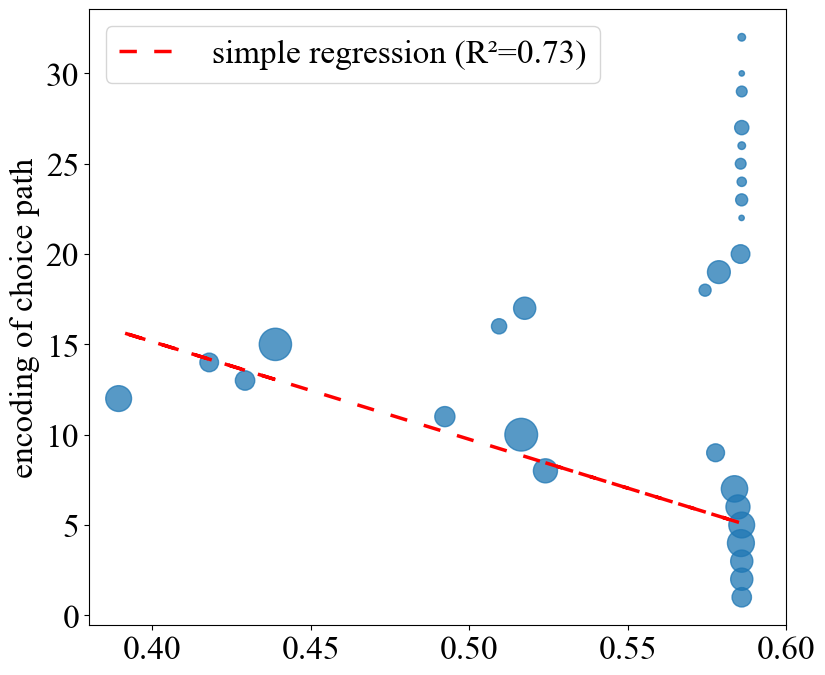

min riskCoef: 0.3893809238987067
max riskCoef: 0.5859177086413573
PearsonRResult(statistic=-0.21691826883443888, pvalue=1.4000495383792641e-05)


In [6]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24

# fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 8))

# ax1.scatter(df_raw_risk['riskCoef'],df_raw_risk['v_110'],s=64)
# ax1.set_xlabel('risk aversion γ')
# ax1.set_ylabel('encoding of choice path')
# ax1.set_xlim((0.3,0.9))

# ax2.scatter(df_raw_risk['temp'],df_raw_risk['v_110'],s=64)
# ax2.set_xlabel('noise λ')
# ax2.set_xlim((0,8))

# plt.legend()
# plt.show()

plt.figure(figsize=(9, 8))

df_scatter_risk = df_raw_risk.groupby(['riskCoef','v_110']).count()['pid'].reset_index()
plt.scatter(df_scatter_risk['riskCoef'],df_scatter_risk['v_110'],
            s=df_scatter_risk['pid']*15, marker='o', alpha=.75)
# plt.xlabel('risk aversion γ')
plt.ylabel('encoding of choice path')
plt.xlim((0.38,0.6))

df_raw_risk_edited = df_raw_risk[df_raw['v_110'] <=16]
slope, intercept, r, p_value, std_err = st.linregress(x=df_raw_risk_edited['riskCoef'], y=df_raw_risk_edited['v_110'])
pred_subgroup = slope * df_raw_risk_edited['riskCoef'] + intercept
plt.plot(df_raw_risk_edited['riskCoef'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='best')
plt.show()

print('min riskCoef:',df_raw_risk['riskCoef'].min())
print('max riskCoef:',df_raw_risk['riskCoef'].max())
print(st.pearsonr(df_raw_risk['riskCoef'],df_raw_risk['v_110']))

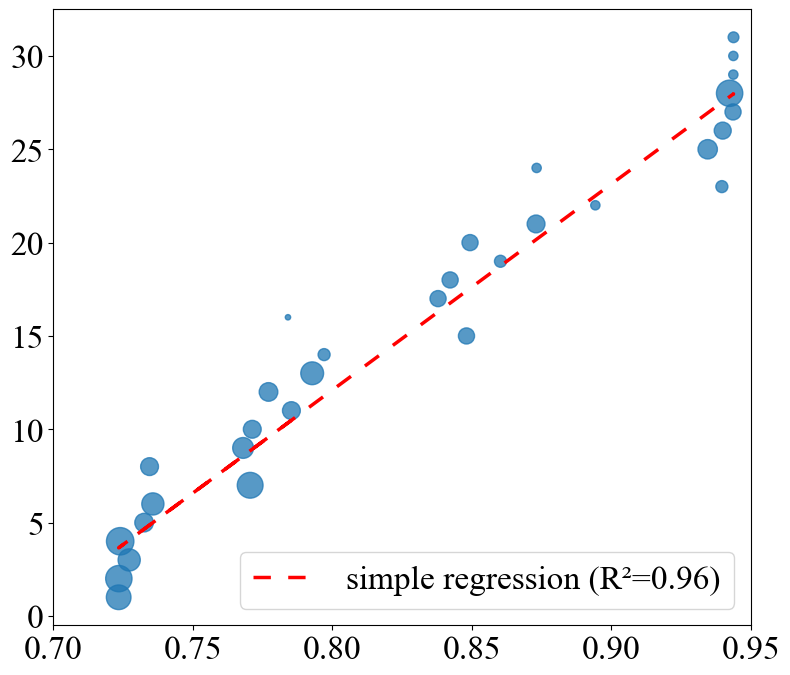

min delta: 0.7234133747929626
max delta: 0.9437860804833382
PearsonRResult(statistic=0.9819173178500827, pvalue=8.413901222028049e-256)


In [185]:
plt.figure(figsize=(9, 8))

df_scatter_time = df_raw_time.groupby(['delta','v_195']).count()['pid'].reset_index()
plt.scatter(df_scatter_time['delta'],df_scatter_time['v_195'],
            s=df_scatter_time['pid']*15, marker='o', alpha=.75)
# plt.xlabel('discount factor δ')
# plt.ylabel('encoding of choice path')
plt.xlim((0.7,0.95))

slope, intercept, r, p_value, std_err = st.linregress(x=df_raw_time['delta'], y=df_raw_time['v_195'])
pred_subgroup = slope * df_raw_time['delta'] + intercept
plt.plot(df_raw_time['delta'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='lower right')
plt.show()

print('min delta:',df_raw_time['delta'].min())
print('max delta:',df_raw_time['delta'].max())
print(st.pearsonr(df_raw_time['delta'],df_raw_time['v_195']))

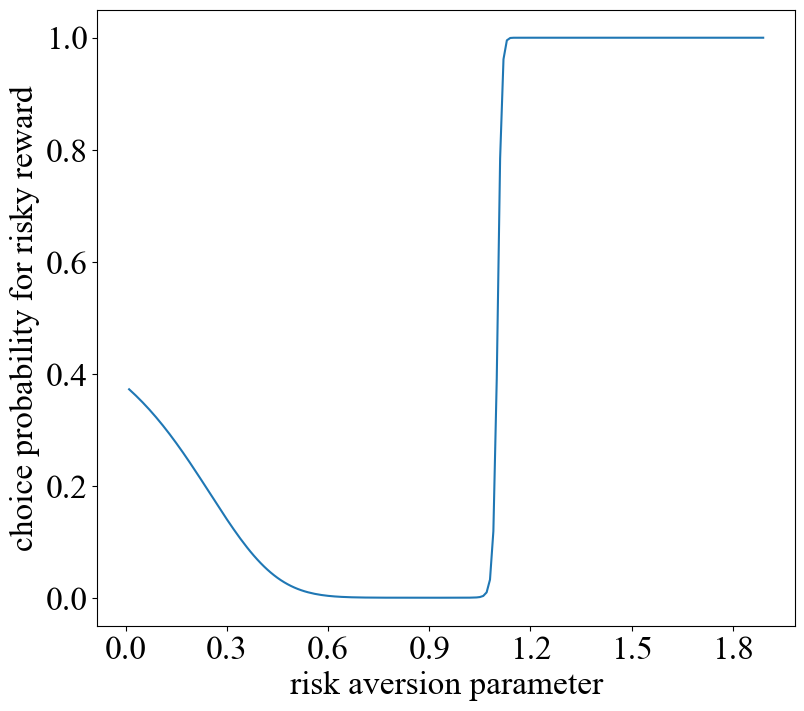

In [37]:
coef = np.arange(0.01,1.9,0.01)

plt.figure(figsize=(9, 8))
plt.plot(coef,1 / (1 + np.exp(- (300**coef * 0.5 - 160**coef))))
plt.xlabel('risk aversion parameter')
plt.ylabel('choice probability for risky reward')
plt.xticks(np.arange(0,2,0.3))
plt.show()

KL Divergence: {'const-model': 0.19778197100957398, 'hetero-model': 0.17510307787799106}
Cross-Entropy: {'const-model': 3.298248145158045, 'hetero-model': 3.275569252026462}
Power_divergenceResult(statistic=18.234278293929936, pvalue=0.9664967699952098)


C:\Users\zarkwang\AppData\Local\Temp\ipykernel_3788\3971179165.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encode_dist = pd.concat([df_const_risk_encode,df_hetero_risk_encode,df_true_risk_ecnode],axis=1).fillna(0)


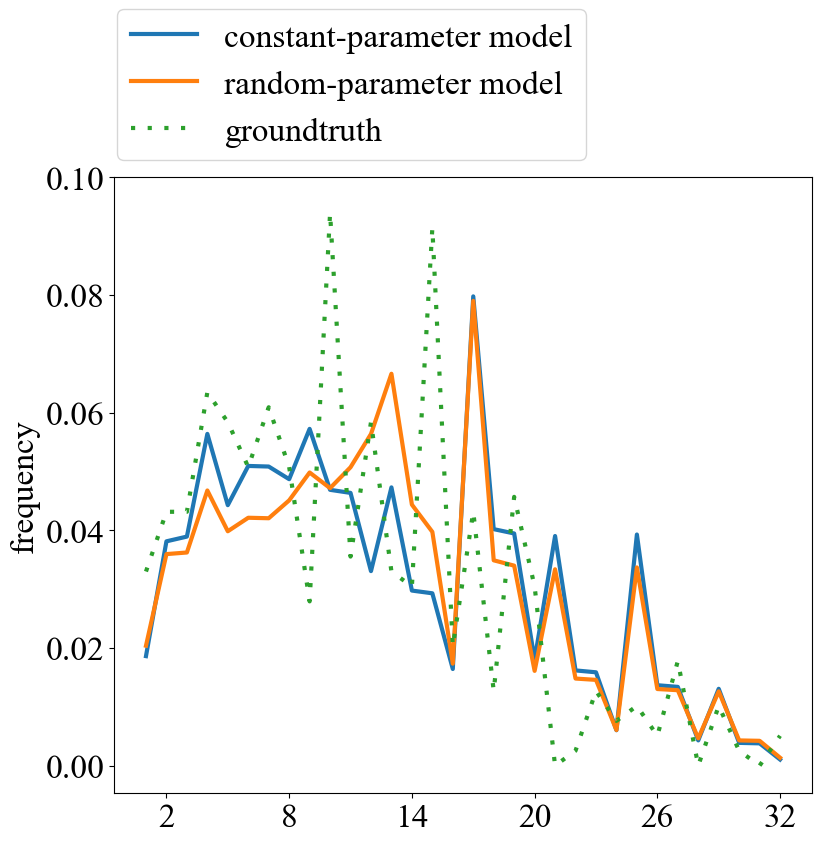

In [195]:
# Constant-parameter model for risk preference 
model = pickle.load(open('models_psm/risk_class_2.pkl', 'rb'))
model.set_init_param(param_keys=['riskCoef','temp'],param_init=[0.5,1.0])
model.fit_param(show=False)
all_args = model.fixed_args | dict(zip(model.param_keys, model.result.x))
df_const_risk_encode = get_model_implied_dist(model,df_risk,all_args)

# Random-parameter model for risk preference
df_hetero_risk_encode = pd.Series([0]*32)
df_hetero_risk_encode.index = np.arange(1,33)

for c in range(2):

    all_args = model.fixed_args | {'riskCoef':model.latent_class['riskCoef'][c]}

    _encode = get_model_implied_dist(model,df_risk,all_args)
    
    df_hetero_risk_encode = df_hetero_risk_encode + _encode * model.latent_share[c]

# True encode of choice paths
df_true_risk_ecnode = df_risk['v_110'].value_counts() / len(df_risk)

# Comparison of distributions
df_encode_dist = pd.concat([df_const_risk_encode,df_hetero_risk_encode,df_true_risk_ecnode],axis=1).fillna(0)
df_encode_dist.columns = ['const_pred','hetero_pred','true']
P = df_encode_dist['true']
Q_const = df_encode_dist['const_pred']
Q_hetero = df_encode_dist['hetero_pred']

# KL Divergence (D_KL(P || Q))
kl_div = {'const-model':st.entropy(P, Q_const),'hetero-model':st.entropy(P, Q_hetero)}
print(f"KL Divergence: {kl_div}")

# Cross entropy H(P,Q)
ce = {'const-model':-np.sum(P * np.log(Q_const)),'hetero-model':-np.sum(P * np.log(Q_hetero))}
print(f"Cross-Entropy: {ce}")

# Chi-square test
print(st.chisquare(Q_hetero*len(model.choice),Q_const*len(model.choice)))

plt.figure(figsize=(9, 8))
plt.plot(df_const_risk_encode.index, df_const_risk_encode,linewidth=3,label='constant-parameter model')
plt.plot(df_hetero_risk_encode.index, df_hetero_risk_encode,linewidth=3,label='random-parameter model')
plt.plot(df_encode_dist['true'].index, df_encode_dist['true'],linestyle=(0,(1,3)),linewidth=3,label='groundtruth')
plt.xticks(np.arange(2,38,6))
plt.yticks(np.arange(0,0.12,0.02))
plt.ylabel("frequency")
plt.legend(loc='upper right',bbox_to_anchor=(0.7, 1.3))

KL Divergence: {'const-model': 0.1978873802807821, 'hetero-model': 0.13874791014614285}
Cross-Entropy: {'const-model': 3.442413017637544, 'hetero-model': 3.383273547502905}
Power_divergenceResult(statistic=46.24598393308442, pvalue=0.03845534554365514)


C:\Users\zarkwang\AppData\Local\Temp\ipykernel_3788\672716504.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encode_dist = pd.concat([df_const_time_encode,df_hetero_time_encode,df_true_time_ecnode],axis=1).fillna(0)


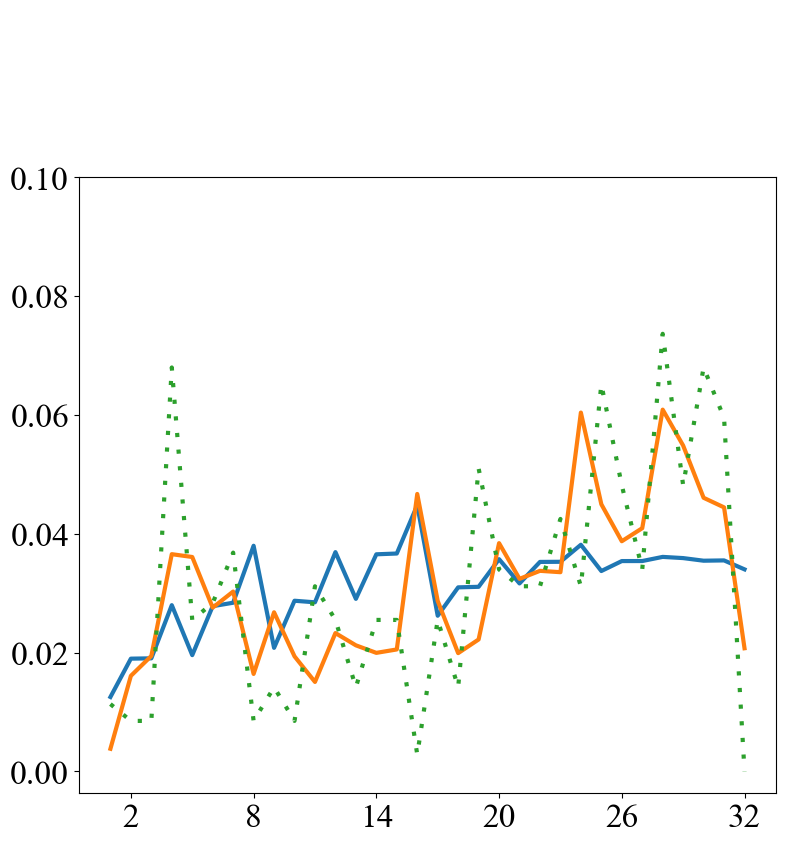

In [196]:
# Constant-parameter model for time preference 
model = pickle.load(open('models_psm/time_class_4.pkl', 'rb'))
model.set_init_param(param_keys=['delta','temp'],param_init=[0.5,1.0])
model.fit_param(show=False)
all_args = model.fixed_args | dict(zip(model.param_keys, model.result.x))
df_const_time_encode = get_model_implied_dist(model,df_time,all_args)

# Random-parameter model for time preference
df_hetero_time_encode = pd.Series([0]*32)
df_hetero_time_encode.index = np.arange(1,33)

for c in range(4):

    all_args = model.fixed_args | {'delta':model.latent_class['delta'][c]}

    _encode = get_model_implied_dist(model,df_time,all_args)
    
    df_hetero_time_encode = df_hetero_time_encode + _encode * model.latent_share[c]

# True encode of choice paths
df_true_time_ecnode = df_time['v_195'].value_counts() / len(df_time)

# Comparison of distributions
df_encode_dist = pd.concat([df_const_time_encode,df_hetero_time_encode,df_true_time_ecnode],axis=1).fillna(0)
df_encode_dist.columns = ['const_pred','hetero_pred','true']
P = df_encode_dist['true']
Q_const = df_encode_dist['const_pred']
Q_hetero = df_encode_dist['hetero_pred']

# KL Divergence (D_KL(P || Q))
kl_div = {'const-model':st.entropy(P, Q_const),'hetero-model':st.entropy(P, Q_hetero)}
print(f"KL Divergence: {kl_div}")

# Cross entropy H(P,Q)
ce = {'const-model':-np.sum(P * np.log(Q_const)),'hetero-model':-np.sum(P * np.log(Q_hetero))}
print(f"Cross-Entropy: {ce}")

# Chi-square test
print(st.chisquare(Q_hetero*len(model.choice),Q_const*len(model.choice)))

plt.figure(figsize=(9, 8))
plt.plot(df_const_time_encode.index, df_const_time_encode,linewidth=3,label='constant-parameter')
plt.plot(df_hetero_time_encode.index, df_hetero_time_encode,linewidth=3,label='random-parameter')
plt.plot(df_encode_dist['true'].index, df_encode_dist['true'],linestyle=(0,(1,3)),linewidth=3,label='groundtruth')
plt.xticks(np.arange(2,38,6))
plt.yticks(np.arange(0,0.12,0.02))
legend = plt.legend(loc='upper right',bbox_to_anchor=(0.5, 1.3),frameon=False)

# Hide legend text
for text in legend.get_texts():
    text.set_color((1, 1, 1, 0))  # Transparent text

# Hide legend lines
for line in legend.get_lines():
    line.set_linestyle("")  # Remove line style
    line.set_marker("")  # Remove markers
    line.set_linewidth(0)  # Set line width to 0


Text(0.5, 0, '(b) discount factor')

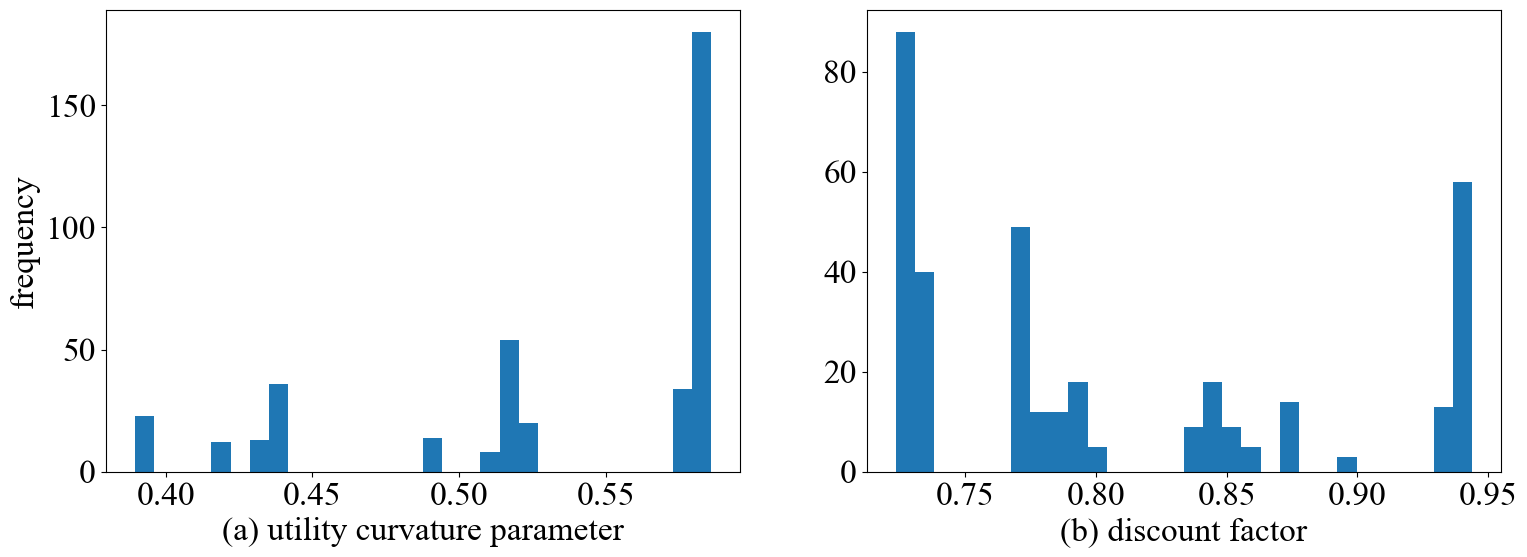

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.hist(df_raw_risk['riskCoef'],bins=30)
ax1.set_xlabel('(a) utility curvature parameter')
ax1.set_ylabel('frequency')

ax2.hist(df_raw_time['delta'],bins=30)
ax2.set_xlabel('(b) discount factor')

In [16]:
df_risk_tmp = df_risk.rename(columns={f'layer_x_{i}':f'x2_{i}' for i in range(1,6)})
df_risk_tmp = df_risk_tmp.rename(columns = {f'layer_choice_{i}':f'choice_{i}' for i in range(1,6)})
df_risk_tmp[[f't2_{i}' for i in range(1,6)]] = 0
df_risk_tmp[[f'p1_{i}' for i in range(1,6)]] = 0.5
df_risk_tmp[[f'x1_{i}' for i in range(1,6)]] = 300


df_time_tmp = df_time.rename(columns={f'layer_x_{i}':f'x2_{i+5}' for i in range(1,6)})
df_time_tmp = df_time_tmp.rename(columns = {f'layer_choice_{i}':f'choice_{i+5}' for i in range(1,6)})
df_risk_tmp[[f't2_{i}' for i in range(6,11)]] = 1.0
df_risk_tmp[[f'p1_{i}' for i in range(6,11)]] = 1.0
df_risk_tmp[[f'x1_{i}' for i in range(6,11)]] = 100


df_joint = pd.merge(left=df_time_tmp,right=df_risk_tmp,on='pid',how='inner')

choice_cols = [f'choice_{i}' for i in range(1,11)]
x1_cols = [f'x1_{i}' for i in range(1,11)]
x2_cols = [f'x2_{i}' for i in range(1,11)]
p1_cols = [f'p1_{i}' for i in range(1,11)]
t2_cols = [f't2_{i}' for i in range(1,11)]

In [29]:
bounds = [(0,1),(0,1)]

model = DCM.mixedDiscrete(data=df_joint,
                choice = choice_cols,
                x1 = x1_cols,
                x2 = x2_cols,
                p1 = p1_cols,
                t2 = t2_cols
                )

model.set_init_param(param_keys=['riskCoef','delta','temp'],param_init=[0.5,0.5,1.0])
model.fit_param()
pred_const_model = model.predict()
pred_const_model['approx_log_like'] = model.result.fun / 1000

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2375534.824988128
        x: [ 4.949e-01  7.108e-01  6.230e+00]
      nit: 17
      jac: [ 5.588e-01 -4.657e-02 -1.397e-01]
     nfev: 104
     njev: 26
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


In [28]:
bounds = [(0,1),(0,1)]

model = DCM.mixedDiscrete(data=df_joint,
                choice = choice_cols,
                x1 = x1_cols,
                x2 = x2_cols,
                p1 = p1_cols,
                t2 = t2_cols,
                fixed_args={'temp':6.23}
                )

model.set_init_param(param_keys=['riskCoef','delta'],param_init=[0.5,0.5])
model.fit_param()

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2375534.825009433
        x: [ 4.949e-01  7.108e-01]
      nit: 8
      jac: [-5.122e-01 -4.191e-01]
     nfev: 42
     njev: 14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


In [22]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=2, n_init_point = 8, name_prefix = 'models_psm/joint')

Searching optimal value for temp
Step 1: 3.533333333333333
Evaluation metrics: 2584.3335568340203, 2496.299880507336
Step 2: 4.088888888888889
Evaluation metrics: 2532.6824650540566, 2398.4233129452678
Step 3: 4.45925925925926
Evaluation metrics: 2502.4243586446646, 2399.365224743128
Step 4: 4.212345679012346
Evaluation metrics: 2398.677466305896, 2400.2444273076544
Step 5: 4.047736625514403
Evaluation metrics: 2398.3544438303875, 2399.1126012857535
Step 6: 3.937997256515775
Evaluation metrics: 2398.2127418215077, 2398.557324491496
Step 7: 3.864837677183356
Evaluation metrics: 2398.15402558316, 2398.2995760957674
Step 8: 3.816064624295077
Evaluation metrics: 2398.1343598313565, 2398.1893487251664
Step 9: 3.848579992887263
Evaluation metrics: 2518.0794867511154, 2398.1465104075864
Step 10: 3.826903080492473
Evaluation metrics: 2398.137581553247, 2398.157601466118


({'temp': 3.826903080492473}, np.float64(2398.136496212082))

In [23]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=3, n_init_point = 8, name_prefix = 'models_psm/joint')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 2640.2453999124887, 2640.2456091264257
Step 2: 2.422222222222222
Evaluation metrics: 2697.1397443172714, 2649.1208904975792
Step 3: 2.0518518518518514
Evaluation metrics: 2619.629828955933, 2632.2267007670234
Step 4: 1.804938271604938
Evaluation metrics: 2651.7298636685136, 2681.8794482570747
Step 5: 1.9695473251028806
Evaluation metrics: 2665.56688935901, 2628.0593374119303
Step 6: 2.0792866941015085
Evaluation metrics: 2628.3096217400494, 2624.9164604130383
Step 7: 2.1524462734339274
Evaluation metrics: 2699.299172313973, 2608.8209340877975
Step 8: 2.2012193263222066
Evaluation metrics: 2700.064272820435, 2615.9869143061414
Step 9: 2.233734694914393
Evaluation metrics: 2619.8147074768185, 2612.888880181449
Step 10: 2.255411607309184
Evaluation metrics: 2649.6593760894684, 2645.880824369953


({'temp': 2.255411607309184}, np.float64(2670.8936693502546))

In [24]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=4, n_init_point = 8, name_prefix = 'models_psm/joint')

Searching optimal value for temp
Step 1: 3.533333333333333
Evaluation metrics: 2755.7789741649667, 2681.5423746832016
Step 2: 4.088888888888889
Evaluation metrics: 2685.724323506347, 2619.617759964636
Step 3: 4.45925925925926
Evaluation metrics: 2737.290538287445, 2618.1660552794206
Step 4: 4.212345679012346
Evaluation metrics: 2621.2753760128744, 2629.658256840028
Step 5: 4.047736625514403
Evaluation metrics: 2619.1312872310696, 2623.765917032292
Step 6: 3.937997256515775
Evaluation metrics: 2617.909944074473, 2621.727815299133
Step 7: 3.864837677183356
Evaluation metrics: 2620.4462361568617, 2623.7492729419105
Step 8: 3.816064624295077
Evaluation metrics: 2619.8634897047477, 2624.686551054944
Step 9: 3.848579992887263
Evaluation metrics: 2704.6918843180742, 2622.0983396051774
Step 10: 3.826903080492473
Evaluation metrics: 2595.5914675516296, 2620.1857128874612


({'temp': 3.826903080492473}, np.float64(2621.057301840323))

In [25]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=5, n_init_point = 8, name_prefix = 'models_psm/joint')

Searching optimal value for temp
Step 1: 1.8666666666666667
Evaluation metrics: 2795.4118469313903, 2807.055814324077
Step 2: 2.422222222222222
Evaluation metrics: 2794.513932084091, 2744.47896805592
Step 3: 2.7925925925925927
Evaluation metrics: 2738.0416344442197, 2714.859858532687
Step 4: 2.545679012345679
Evaluation metrics: 2672.4532744456037, 2742.298960890801
Step 5: 2.3810699588477364
Evaluation metrics: 2752.2617001701656, 2765.6404306300187
Step 6: 2.4908093278463648
Evaluation metrics: 2794.387105787785, 2714.440120650879
Step 7: 2.417649748513946
Evaluation metrics: 2799.348310907103, 2828.6382037580975
Step 8: 2.3688766956256666
Evaluation metrics: 2773.499008897619, 2834.8912321794874
Step 9: 2.3363613270334804
Evaluation metrics: 2677.744369325592, 2719.7295821200996
Step 10: 2.3580382394282715
Evaluation metrics: 2837.4025558875564, 2777.1854593057865


({'temp': 2.3580382394282715}, np.float64(2798.954648071833))

In [26]:
DCM.bisection_search(model, bounds, arg_name = 'temp', arg_range = [0.2, 5.2],
                     n_class=6, n_init_point = 8, name_prefix = 'models_psm/joint')

Searching optimal value for temp
Step 1: 3.533333333333333
Evaluation metrics: 2860.3329978344996, 2823.5068282917437
Step 2: 2.977777777777778
Evaluation metrics: 2792.748951111565, 2832.32132462491
Step 3: 3.348148148148148
Evaluation metrics: 2865.1564230026092, 2834.445836110158
Step 4: 3.1012345679012343
Evaluation metrics: 2807.57683498632, 2837.0214865032217
Step 5: 3.265843621399177
Evaluation metrics: 2856.547220780969, 2853.4797478882983
Step 6: 3.375582990397805
Evaluation metrics: 2852.098037244755, 2834.241332785903
Step 7: 3.448742569730224
Evaluation metrics: 2852.6239680928993, 2819.9101739736834
Step 8: 3.4975156226185034
Evaluation metrics: 2879.1523303020267, 2765.8055897481336
Step 9: 3.465000254026317
Evaluation metrics: 2799.857868907265, 2800.535357995608
Step 10: 3.443323341631526
Evaluation metrics: 2783.5344187041483, 2787.3648221850563


({'temp': 3.443323341631526}, np.float64(2788.0847027193217))

In [30]:
print('const params:',pred_const_model)
for i in range(2,7):
    model = pickle.load(open(f'models_psm/joint_class_{i}.pkl', 'rb'))
    pred_metric = model.predict()
    pred_metric['approx_log_like'] = model.eval()
    print(f'model {i}:', pred_metric)

# normal_model = pickle.load(open('models_psm/time_normal.pkl', 'rb'))
# pred_normal = normal_model.choicePred()
# pred_normal['approx_log_like'] = normal_model.obj_func
# print('normal:',pred_normal)

const params: {'accuracy': np.float64(0.5813031161473088), 'RMSE': np.float64(0.24008713520023844), 'cross-entropy': np.float64(0.6729560410731241), 'approx_log_like': np.float64(2375.534824988128)}
model 2: {'accuracy': np.float64(0.6082152974504249), 'RMSE': np.float64(0.22583713056981197), 'cross-entropy': np.float64(0.6409335180050184), 'approx_log_like': np.float64(2398.136496212082)}
model 3: {'accuracy': np.float64(0.5801699716713881), 'RMSE': np.float64(0.23603414626616082), 'cross-entropy': np.float64(0.6635285242690669), 'approx_log_like': np.float64(2670.8936693502546)}
model 4: {'accuracy': np.float64(0.639943342776204), 'RMSE': np.float64(0.21575924638537525), 'cross-entropy': np.float64(0.6188580609279893), 'approx_log_like': np.float64(2621.057301840323)}
model 5: {'accuracy': np.float64(0.5838526912181303), 'RMSE': np.float64(0.23314626891884138), 'cross-entropy': np.float64(0.6573549245421353), 'approx_log_like': np.float64(2798.954648071833)}
model 6: {'accuracy': np.

In [40]:
model = pickle.load(open('models_psm/joint_class_4.pkl', 'rb'))

df_raw_time['delta_joint'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)

df_raw_time_edited = df_raw_time[df_raw_time['x_time_0_12_av'].notna()]
endog = df_raw_time_edited['x_time_0_12_av']
exog = sm.add_constant(df_raw_time_edited[['delta_joint']].astype(float))

reg_model = sm.OLS(endog,exog).fit().get_robustcov_results(cov_type='HC1')
reg_model.summary()

C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_12968\3414728733.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw_time['delta_joint'] = (model.post_prob * model.latent_class['delta']).sum(axis=1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         x_time_0_12_av   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     48.15
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           2.02e-11
Time:                        00:33:15   Log-Likelihood:                -1151.8
No. Observations:                 341   AIC:                             2308.
Df Residuals:                     339   BIC:                             2315.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -8.8706      3.219     -2.756      0.006     -15.202      -2.539
delta_joint    29.4457      4.244      6.939      0.000      21.098      37.793
==============================================================================
Omnibus:                       86.998   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.235
Skew:                           0.070   Prob(JB):                     0.000298
Kurtosis:                       1.940   Cond. No.                         22.6
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [43]:
df_new_risk = df_raw_risk[df_raw_risk['pid'].isin(df_joint['pid'])]
df_new_risk['riskCoef_joint'] = 1 - (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)

df_new_risk[f'riskCoefRiskSeek_joint'] = df_new_risk['riskCoef_joint'] * df_new_risk['isRiskSeeking']

df_new_risk_edited = df_new_risk[df_new_risk['x_risk_av'].notna()]
endog = df_new_risk_edited['x_risk_av']
exog = sm.add_constant(df_new_risk_edited[['riskCoef_joint','isRiskSeeking','riskCoefRiskSeek_joint']].astype(float))

reg_model = sm.OLS(endog,exog).fit().get_robustcov_results(cov_type='HC1')
reg_model.summary()

C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_12968\844407881.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_risk['riskCoef_joint'] = 1 - (model.post_prob * model.latent_class['riskCoef']).sum(axis=1)
C:\Users\phd19zw1\AppData\Local\Temp\ipykernel_12968\844407881.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_risk[f'riskCoefRiskSeek_joint'] = df_new_risk['riskCoef_joint'] * df_new_risk['isRiskSeeking']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              x_risk_av   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     14.82
Date:                Fri, 28 Feb 2025   Prob (F-statistic):           4.38e-09
Time:                        00:35:14   Log-Likelihood:                -830.51
No. Observations:                 341   AIC:                             1669.
Df Residuals:                     337   BIC:                             1684.
Df Model:                           3                                         
Covariance Type:                  HC1                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     11.4413      0.582     19.671      0.000      10.297      12.585
riskCoef_joint            -3.3392      1.143     -2.922      0.004      -5.587      -1.092
isRiskSeeking              0.9240      1.522      0.607      0.544      -2.070       3.918
riskCoefRiskSeek_joint     2.6114      2.606      1.002      0.317      -2.515       7.738
==============================================================================
Omnibus:                        7.304   Durbin-Watson:                   1.905
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                9.539
Skew:                           0.176   Prob(JB):                      0.00849
Kurtosis:                       3.740   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

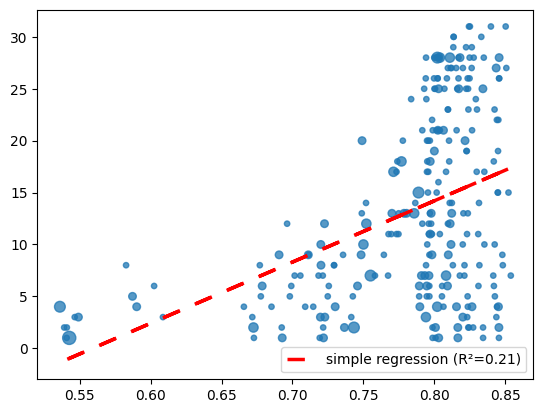

min delta: 0.5359658775063336
max delta: 0.8540724170102378
PearsonRResult(statistic=np.float64(0.4609750248647674), pvalue=np.float64(5.662698297536349e-20))


In [38]:
# plt.figure(figsize=(9, 8))

df_scatter_time = df_raw_time.groupby(['delta_joint','v_195']).count()['pid'].reset_index()
plt.scatter(df_scatter_time['delta_joint'],df_scatter_time['v_195'],
            s=df_scatter_time['pid']*15, marker='o', alpha=.75)
# plt.xlim((0.7,0.95))

slope, intercept, r, p_value, std_err = st.linregress(x=df_raw_time['delta_joint'], y=df_raw_time['v_195'])
pred_subgroup = slope * df_raw_time['delta_joint'] + intercept
plt.plot(df_raw_time['delta_joint'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='lower right')
plt.show()

print('min delta:',df_raw_time['delta_joint'].min())
print('max delta:',df_raw_time['delta_joint'].max())
print(st.pearsonr(df_raw_time['delta_joint'],df_raw_time['v_195']))

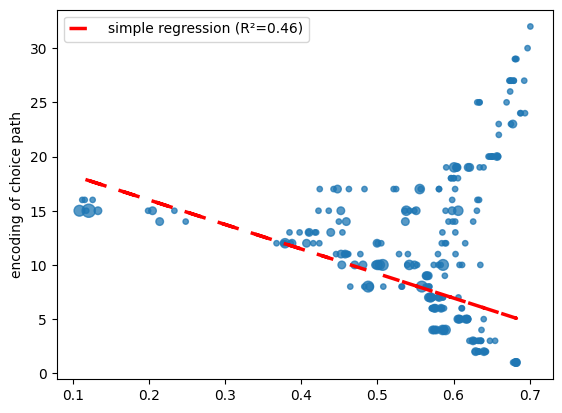

min riskCoef: 0.10813190365218828
max riskCoef: 0.7010449061160996
PearsonRResult(statistic=np.float64(-0.08290946439010188), pvalue=np.float64(0.1199745477400433))


In [44]:
df_scatter_risk = df_new_risk.groupby(['riskCoef_joint','v_110']).count()['pid'].reset_index()
plt.scatter(df_scatter_risk['riskCoef_joint'],df_scatter_risk['v_110'],
            s=df_scatter_risk['pid']*15, marker='o', alpha=.75)
# plt.xlabel('risk aversion γ')
plt.ylabel('encoding of choice path')
# plt.xlim((0.38,0.6))

df_new_risk_edited = df_new_risk[df_new_risk['isRiskSeeking'] == False]
slope, intercept, r, p_value, std_err = st.linregress(x=df_new_risk_edited['riskCoef_joint'], y=df_new_risk_edited['v_110'])
pred_subgroup = slope * df_new_risk_edited['riskCoef_joint'] + intercept
plt.plot(df_new_risk_edited['riskCoef_joint'], pred_subgroup, color='red', linestyle=(0,(5,5)), linewidth = 2.5, 
         label= f"simple regression (R²={r**2:.2f})")

plt.legend(loc='best')
plt.show()

print('min riskCoef:',df_new_risk['riskCoef_joint'].min())
print('max riskCoef:',df_new_risk['riskCoef_joint'].max())
print(st.pearsonr(df_new_risk['riskCoef_joint'],df_new_risk['v_110']))